# Preliminary analysis of the master sample

In this notebook, we read LINEAR_Periods_nterm3.txt and produce a few characteristic color-color and other plots. Also, a sample of 2710 RR Lyrae stars is defined using the g-i color and light curve shape, and subsamples of ab and c type RR Lyrae are compared to each other. 

For this sample of 2710 RR Lyrae stars, we need to compute ZTF periods and compare them to LINEAR periods.

In [1]:
# importing all of the necessary libraries
import numpy as np
import seaborn as sns
import pandas as pd
import scipy as sc
import random
import pickle

from astropy.table import Table

from matplotlib import pyplot as plt
from scipy.stats import norm

from astroML.utils.decorators import pickle_results
from astroML.time_series import search_frequencies, lomb_scargle, MultiTermFit
from gatspy import periodic
from astropy.timeseries import LombScargle
from astroML.datasets import fetch_LINEAR_sample

from ztfquery import lightcurve
from matplotlib import ticker
import dask.dataframe as dd 
from concurrent.futures import ThreadPoolExecutor
from concurrent.futures import ProcessPoolExecutor
import threading
import os

np.random.seed(42)
%matplotlib inline  

In [2]:
sns.set_theme() # setting the theme for plotting

In [3]:
import sys
sys.path.insert(0,'../src/')
sys.path
from ZTF_data import data_ztf

In [ ]:
from descriptive_stats import*
from plotting import*
from config import*
from periods import*

# `LINEAR` dataset

In [4]:
# read data for the master sample of 5204 stars with reliable and reproducible LINEAR periods
colnames = ['ID','Porig','Pnew','ra','dec', 'ug','gi','iK','JK','logP','Ampl','skew','kurt','magMed','nObs','LCtype']
L = Table.read('./LINEAR_Periods_nterm3.txt', format='ascii', names=colnames)

In [5]:
L

ID,Porig,Pnew,ra,dec,ug,gi,iK,JK,logP,Ampl,skew,kurt,magMed,nObs,LCtype
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64
29848,0.55700898,0.55701916,119.526443,46.96212,1.17,0.37,1.02,0.27,-0.2541378,0.62,-0.31,-0.57,16.37,301,1
32086,0.56925794,0.56926594,119.324013,47.095505,1.36,0.52,1.17,0.31,-0.2446909,0.71,-0.49,-1.0,15.02,289,1
50402,0.64329296,0.6432861,119.712975,52.149574,1.18,0.39,1.1,0.2,-0.1915912,0.49,-0.29,-0.88,16.46,284,1
61011,0.662369,0.66237568,118.491257,53.168125,0.81,0.55,1.62,0.2,-0.1789,0.69,-0.03,-1.06,14.08,274,1
62892,0.53077199,0.53076395,119.187241,53.379295,1.12,0.21,1.07,0.21,-0.275092,0.62,-0.55,-0.32,16.54,276,1
91437,0.6747281,0.67471133,120.29496,40.932457,1.18,0.24,1.09,0.37,-0.1708712,0.75,-0.12,-0.93,15.39,177,1
95250,0.31386898,0.31386924,120.124542,40.65662,1.18,-0.14,0.83,0.28,-0.5032516,0.55,0.14,-0.65,16.98,222,2
104455,0.55851803,0.55850723,121.150764,42.483574,1.27,-0.13,1.04,0.74,-0.2529628,0.86,-0.34,-0.13,16.88,119,1
108513,0.47380899,0.47381616,120.915886,42.512482,1.24,-0.05,0.8,0.06,-0.3243967,0.85,-1.17,1.16,16.69,282,1


### Example plots

In [6]:
# first split by agreement between the periods 
Pratio = L['Porig']/L['Pnew'] 
L1 = L[(Pratio>0.99)&(Pratio<1.01)]  # these are expected to be RR Lyrae
L2 = L[(Pratio>1.96)&(Pratio<2.04)]  # these are expected to be eclipsing binary stars

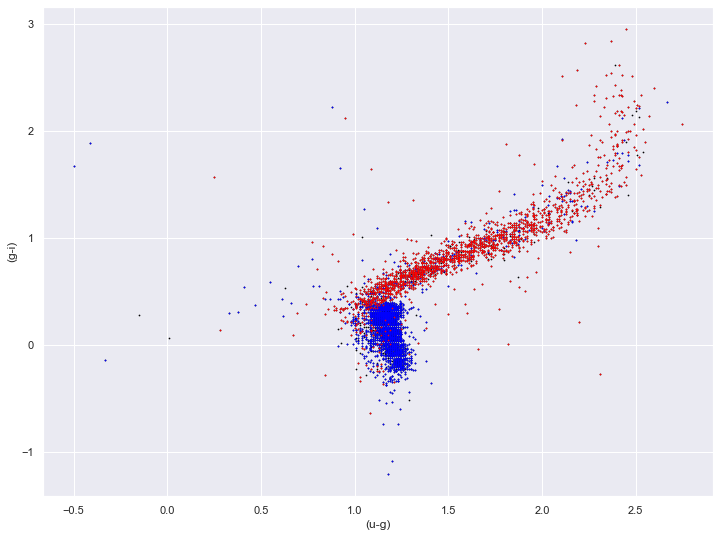

In [7]:
# plot the g-i vs. u-g color-color diagram (which separates RR Lyrae and eclipsing binary stars)
fig,ax = plt.subplots(1,1,figsize=(12,9))
ax.set_xlabel('(u-g)')
ax.set_ylabel('(g-i)')
ax.scatter(L['ug'], L['gi'], s=0.5, c='black') 
ax.scatter(L1['ug'], L1['gi'], s=0.5, c='blue') 
ax.scatter(L2['ug'], L2['gi'], s=0.5, c='red') 

Yay! RR Lyrae and eclipsing binary stars are indeed well separated by the g-i color (at about 0.3)

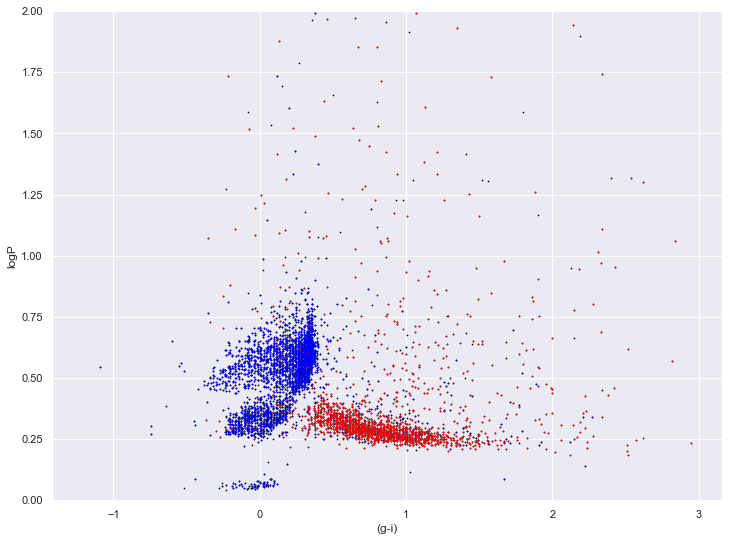

In [10]:
# another "sanity check" plot: period (actually, logP) vs. g-i
fig,ax = plt.subplots(1,1,figsize=(12,9))
ax.set_ylim(0,2) 
ax.set_xlabel('(g-i)')
ax.set_ylabel('logP')
ax.scatter(L['gi'], L['Porig'], s=0.5, c='black') 
ax.scatter(L1['gi'], L1['Porig'], s=0.5, c='blue') 
ax.scatter(L2['gi'], L2['Porig'], s=0.5, c='red') 

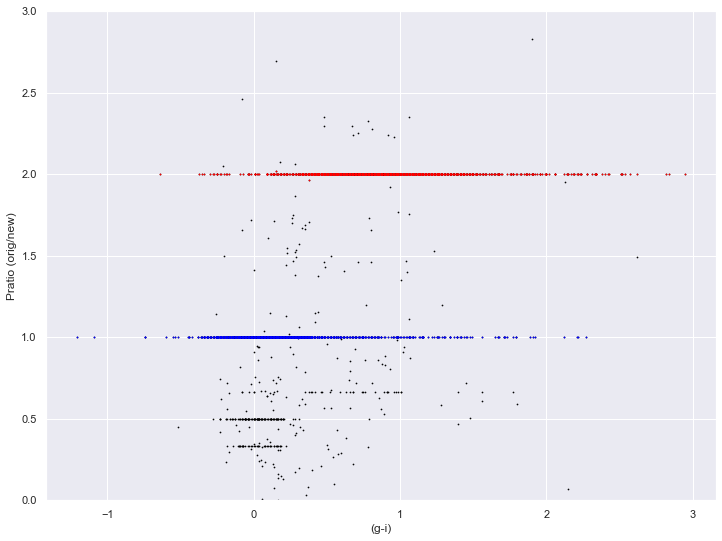

In [14]:
# yet another plot to see how many stars don't have period ratio 1 or 2 (Pratio histogram would be ok, too)
fig,ax = plt.subplots(1,1,figsize=(12,9))
ax.set_ylim(0,3) 
ax.set_xlabel('(g-i)')
ax.set_ylabel('Pratio (orig/new)')
Pratio1 = L1['Porig']/L1['Pnew']
Pratio2 = L2['Porig']/L2['Pnew']
ax.scatter(L['gi'], Pratio, s=0.5, c='black')  
ax.scatter(L1['gi'], Pratio1, s=0.5, c='blue')  
ax.scatter(L2['gi'], Pratio2, s=0.5, c='red')  

In [23]:
# select RR Lyrae using g-i color and previous light curve classification
# note: they also have nterm=3 periods that agree with old periods
# this is the sample to use with ZTF data to get nterm=3 ZTF periods
# (and then compare to these LINEAR periods, i.e. to Lrrlyr['Pnew'])
Lrrlyr = L1[(L1['gi']>-0.5)&(L1['gi']<0.4)&(L1['LCtype']>0)&(L1['LCtype']<3)]
len(Lrrlyr)

2710

In [24]:
# LCtype=1 is ab RR Lyrae, and LCtype=2 is c type
# it will be interesting to see if they show different Blazhko effects 
Lab = Lrrlyr[Lrrlyr['LCtype']==1]
Lc = Lrrlyr[Lrrlyr['LCtype']==2]
print(len(Lab), len(Lc))

2144 566


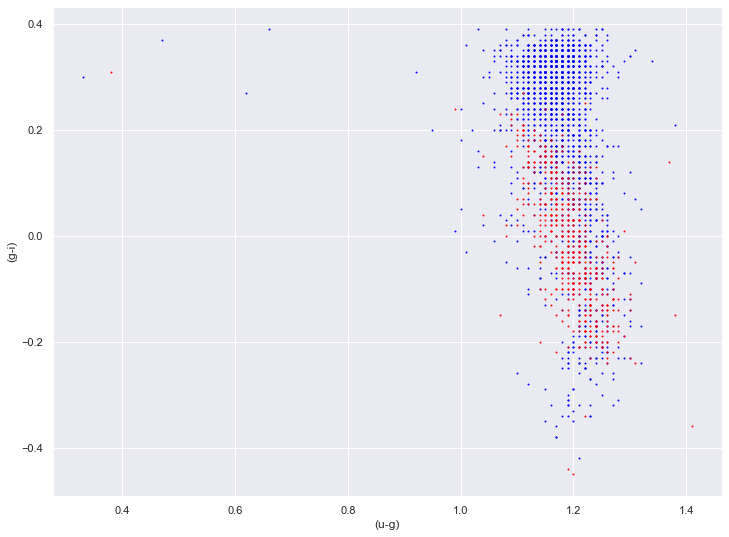

In [26]:
# plotting the g-i vs. u-g color-color diagram: ab type should be separated from c type 
fig,ax = plt.subplots(1,1,figsize=(12,9))
ax.set_xlabel('(u-g)')
ax.set_ylabel('(g-i)')
ax.scatter(Lab['ug'], Lab['gi'], s=0.9, c='blue') 
ax.scatter(Lc['ug'], Lc['gi'], s=0.9, c='red') 

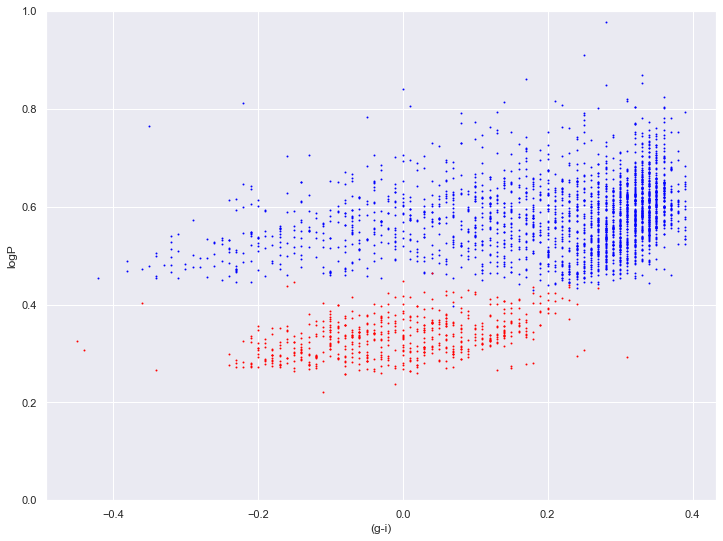

In [29]:
# another "sanity check" plot: note that c type have shorter periods than ab type
fig,ax = plt.subplots(1,1,figsize=(12,9))
ax.set_ylim(0,1) 
ax.set_xlabel('(g-i)')
ax.set_ylabel('logP')
ax.scatter(Lab['gi'], Lab['Porig'], s=0.9, c='blue') 
ax.scatter(Lc['gi'], Lc['Porig'], s=0.9, c='red') 

## next step: compute ZTF periods with nterms=3 for these 2710 RR Lyrae stars...

In [32]:
# the range of the number of LINEAR data points 
print(np.min(Lrrlyr['nObs']), np.median(Lrrlyr['nObs']), np.max(Lrrlyr['nObs']))

42 230.0 1150


In [34]:
# we have almost a million data points in this master sample!
np.sum(Lrrlyr['nObs'])

733550